In [35]:
import os, sys, inspect
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

torch.set_default_dtype(torch.float32)
sys.path.append(os.path.abspath(".."))

# DPI_DIR = "E:\Code\DPI-main\DPItorch"

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
#
from generative_model import realnvpfc_model, glow_model
# from DPI_PET import ImgLogScale

In [36]:
class ImgLogScale(torch.nn.Module):
    """learnable global scale   image = softplus(raw) * exp(log_scale)"""
    def __init__(self, init_scale=1.0):
        super().__init__()
        self.log_scale = torch.nn.Parameter(torch.tensor([np.log(init_scale)], dtype=torch.float32))

    def forward(self):
        return self.log_scale

# Load the learned DPI normalizing flow for MRI

In [37]:
# ——— 配置 ———
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

npix      = 128                 # 跟你训练时 --npix 一致
n_flow    = 4                   # 跟你训练时 --n_flow 一致
model_form= "realnvp"           # 或者 "glow"
checkpoint_dir = "..\checkpoint\pet"

model_file    = os.path.join(checkpoint_dir, "generativemodel_realnvp.pth")
logscale_file = os.path.join(checkpoint_dir, "logscale_realnvp.pth")

# 打印路径（调试用）
print(f"Model file path: {model_file}")
print(f"Logscale file path: {logscale_file}")

# 检查文件是否存在
if not os.path.exists(model_file):
    raise FileNotFoundError(f"Model file not found: {model_file}")
if not os.path.exists(logscale_file):
    raise FileNotFoundError(f"Logscale file not found: {logscale_file}")


Using device: cuda
Model file path: ..\checkpoint\pet\generativemodel_realnvp.pth
Logscale file path: ..\checkpoint\pet\logscale_realnvp.pth


In [29]:
# ——— 构建网络 ———
print("Loading flow model...")
if model_form == "realnvp":
    net = realnvpfc_model.RealNVP(npix*npix, n_flow, affine=True).to(device)
else:
    from generative_model.glow_model import calc_z_shapes, Glow
    z_shapes = calc_z_shapes(1, npix, n_flow, 4)
    net = Glow(1, n_flow, 4, affine=True).to(device)

# recreate the same Img_logscale module
logscale = ImgLogScale(init_scale=1.0).to(device)

# load flow model weights
net.load_state_dict(torch.load(model_file, map_location=device))

# # load just the tensor for logscale
# saved_logscale = torch.load(logscale_file, map_location=device)
# # assign into our module
# with torch.no_grad():
#     # if saved_logscale is a plain tensor, assign it to our parameter
#     logscale.log_scale.copy_(saved_logscale)
#
# 加载缩放因子（兼容两种保存方式）
saved_logscale = torch.load(logscale_file, map_location=device)
if isinstance(saved_logscale, dict):
    # 情况1: 保存的是 state_dict
    logscale.load_state_dict(saved_logscale)
else:
    # 情况2: 保存的是张量
    with torch.no_grad():
        logscale.log_scale.copy_(saved_logscale)

# 设为评估模式
net.eval()
logscale.eval()

Loading flow model...


ImgLogScale()

# Generate and plot image samples

In [30]:
# ——— 采样 & 拼图可视化 ———
n_sample = 128    # 4x4 网格
print(f"Sampling {n_sample} PET images...")
with torch.no_grad():
    if model_form == "realnvp":
        z = torch.randn(n_sample, npix*npix, device=device)
    else:
        z = [torch.randn(n_sample, *s, device=device) for s in z_shapes]
    img_samp, _ = net.reverse(z)
    img_samp = img_samp.reshape(n_sample, npix, npix)

    img_pred = F.softplus(img_samp) * torch.exp(logscale())

# 转成 NumPy
images = img_pred.cpu().numpy()

Sampling 128 PET images...


(<Figure size 1500x1500 with 1 Axes>,
 Text(0.5, 1.0, 'DPI generated PET image samples'))

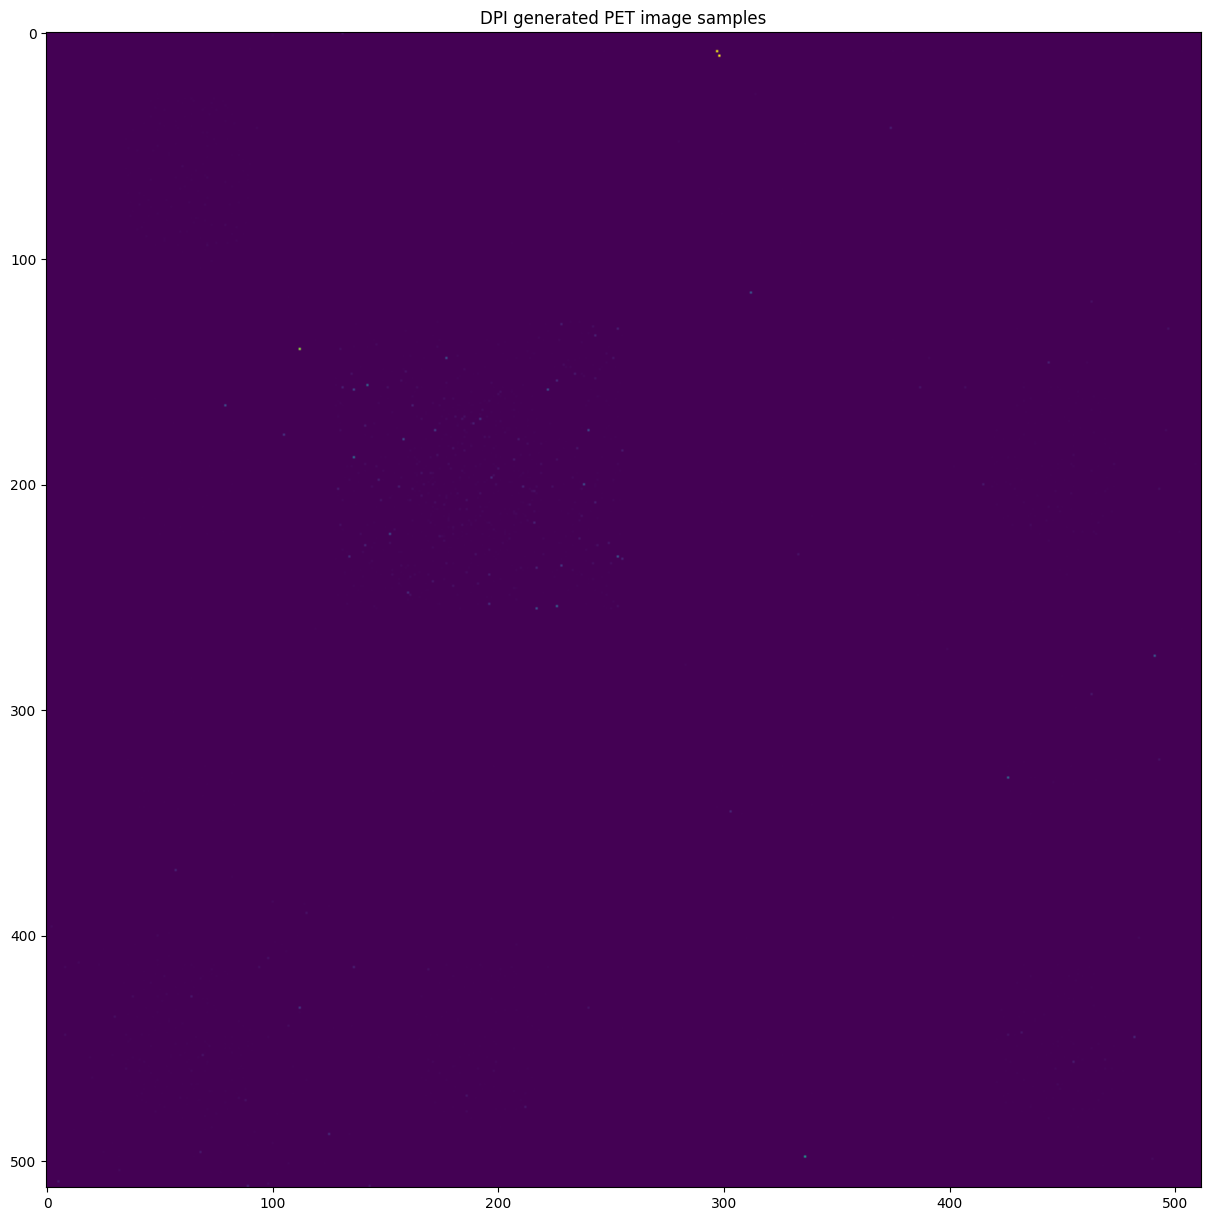

In [34]:
# 拼成 4x4 网格
# n_sample = 16
# grid_rows = int(np.ceil(np.sqrt(n_sample)))
# grid_cols = grid_rows
# stitched = np.zeros((grid_rows*npix, grid_cols*npix), dtype=float)
# for idx in range(n_sample):
#     r, c = divmod(idx, grid_cols)
#     stitched[r*npix:(r+1)*npix, c*npix:(c+1)*npix] = images[idx]
#
# plt.figure(figsize=(8,8))
# plt.imshow(stitched, cmap="hot")
# plt.axis("off")
# plt.title("DPI-PET Generated Samples")
# plt.show()
image_stitch = np.zeros((npix*4, npix*4))
for k in range(16):
    i = k//4
    j = k%4
    image_stitch[npix*i:npix*(i+1), npix*j:npix*(j+1)] = images[k]
plt.figure(figsize = (15,15)), plt.imshow(image_stitch), plt.title('DPI generated PET image samples')

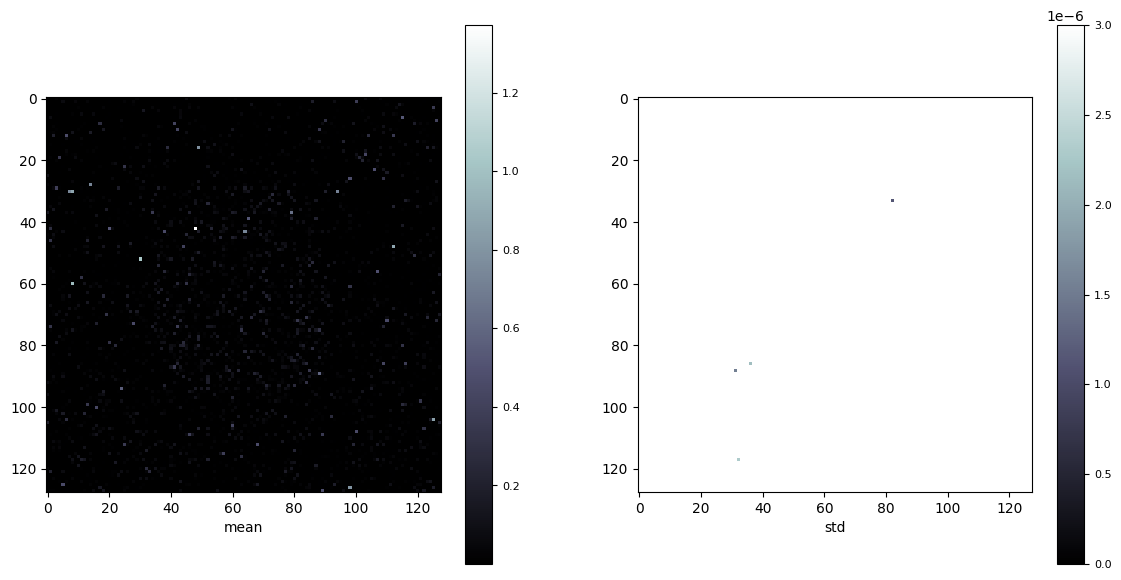

In [32]:
# # 均值 / 标准差
# mean_img = images.mean(axis=0)
# std_img  = images.std(axis=0)
#
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# im = ax1.imshow(mean_img, cmap="hot")
# ax1.set_title("Mean over samples")
# fig.colorbar(im, ax=ax1)
# im = ax2.imshow(std_img, cmap="hot")
# ax2.set_title("Std over samples")
# fig.colorbar(im, ax=ax2)
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# plot mode#1
im = axs[0].imshow(np.mean(images, 0), cmap='bone')
axs[0].set(xlabel='mean')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.tick_params(labelsize=8)

im = axs[1].imshow(np.std(images, 0), cmap='bone', vmin=0, vmax=3e-6)
axs[1].set(xlabel='std')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.tick_params(labelsize=8)